In [3]:
import pandas as pd
from nltk.corpus import stopwords
import nltk.data
import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
df = pd.read_csv('untappd_beers.csv',encoding='latin-1')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df

,Name,style,IBU,ABV,Description
0,Vicinity,IPA - Imperial / Double,65,8.0,Originally brewed in celebration of the first ...
1,Galaxy Dry Hopped Fort Point,Pale Ale - American,45,6.6,This version of our signature American pale al...
2,Launch Beer,Pale Ale - American,68,5.7,First brewed to commemorate the grand opening ...
3,Julius,IPA - American,72,6.8,"Bursting with pungent American hops, Julius - ..."
4,Haze,IPA - Imperial / Double,90,8.2,Our Double IPA! We smell a ton of peach on the...
...,...,...,...,...,...
536,Mexican Dark Lager,Lager - Vienna,24,5.0,Port Cityâs Mexican Dark Lager draws inspira...
537,Ideaal Tripel,Belgian Tripel,35,8.5,Drawing inspiration from Belgiumâs monastic ...
538,Hazy ipa,IPA - New England / Hazy,35,6.8,"Brewed to highlight hop aroma and flavor, Hazy..."
539,Star SailorÂ®,IPA - White,40,6.2,"Exploring the limits of IPAs, Star SailorÂ® Wh..."


In [24]:
#every unique stye of beer in the df
styles = df['style'].unique().tolist()
styles

['IPA - Imperial / Double',
 'Pale Ale - American',
 'IPA - American',
 'Stout - Milk / Sweet',
 'IPA - New England / Hazy',
 'Stout - Oatmeal',
 'MÃ¤rzen',
 'Bock - Single / Traditional',
 'Pumpkin / Yam Beer',
 'Pale Ale - Belgian',
 'Blonde Ale',
 'Pilsner - Czech',
 'Stout - Imperial / Double Oatmeal',
 'IPA - Triple New England / Hazy',
 'Stout - Imperial / Double',
 'Barleywine - English',
 'Stout - Imperial / Double Milk',
 'Porter - Imperial / Double',
 'Sour - Berliner Weisse',
 'Belgian Quadrupel',
 'Barleywine - American',
 'Stout - Russian Imperial',
 'Barleywine - Other',
 'Stout - Foreign / Export',
 'Farmhouse Ale - Saison',
 'Lager - Helles',
 'Stout - Imperial / Double Coffee',
 'Stout - Imperial / Double Pastry',
 'Stout - Other',
 'Wild Ale - American',
 'Sour - Other',
 'Wild Ale - Other',
 'IPA - Imperial / Double New England / Hazy',
 'Sour - Flanders Oud Bruin',
 'Wheat Beer - Witbier / Blanche',
 'Pilsner - German',
 'Belgian Tripel',
 'Pale Ale - New England / 

In [25]:

#using this cell to test and see how many beers that have the word <blank> in them
#  ie. 'IPA',' Wheat', 'Pale Ale', etc. 
style_df = df[df['style'].str.contains('Honey')]
style_df.shape

(1, 6)

#### These are the current counts of each type of beer

In [10]:
# IPA 218
# Stout 92
# Wild Ale [Sour - Fruited Gose, Sour - Fruited, Sour - Berlinner Weisse] 63
# Pale Ale 40
# lager [Pilsner, Bock, Marzen] 27
# Belgian ['Belgian Pale Ale','Belgian Strong Pale Ale','Belgian Dark Ale','Saison / Farmhouse Ale', 'Tripel','Dubbel'] 15
# Porter 11
# Wheat Beer 11

#need to get more of everything especially wheat, porter, belgian, lager, pale ale


### Getting Data ready for Model
- I'm starting off identifying IPAs among other other specific beer types
- The goal will be to make it 50/50 split of IPAs to non IPAs
- I'll use: Stout, Sours, Pale Ale, and Lager, and mayyybe Belgian (haven't included Belgian yet)

In [26]:
#creates binary identifying column 'is_IPA'
df['is_IPA'] = [0]*len(df)
for i in range(len(df)):
    if 'IPA' in df['style'].iloc[i]:
        df['is_IPA'].iloc[i]=1

C:\Users\612456\AppData\Local\Temp\1\ipykernel_17360\3586612665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_IPA'].iloc[i]=1


In [2]:
### testing with new data

In [42]:
df = pd.read_csv('cleaned_data.csv',encoding='latin-1')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [43]:
### testing with new data

In [44]:
# gets the 'Descriptions' to be all lower case
for i in range(len(df)):
    df['Description'].iloc[i] = df['Description'].iloc[i].lower()

C:\Users\612456\AppData\Local\Temp\2\ipykernel_12480\446356232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'].iloc[i] = df['Description'].iloc[i].lower()


#### Scratch words
These words are identifying words, and could potentially give the Beer's style away. Words like the name of the beer and other similar words are included

In [45]:
#words that I need to remove from the descriptions of the beers because they will give the style away
scratch_words = ['ipa', 'hazy', 'west coast', 'belgian', 'porter', 'pale', 'ale', 'wild', 'sour', 'stout', 
                 'lager', 'saison', 'farmhouse', 'dubbel', 'tripel', 'mã¤rzen', 'tree house family', 'american',
                 'india', 'blonde', 'brown ale', 'wheat', 'whitbier', 'blonde', 'Hefeweizen', 'Kristallweizen', 
                 'Dunkelweizen', 'Hopfenweisse', 'Baltic', 'Read Less', 'Other'
                ]
# might keep 'hazy', but could be too obvious (haze is still in a fewof them and I think that is good)

In [8]:
## Skipping this with new test

In [29]:
#creating a df of just the styles of beer that I want to test against
tst_styles = ['IPA', 'Stout', 'Wild', 'Sour', 'Pale Ale', 'Lager', 'Pilsner', 'Bock', 'MÃ¤rzen']
test_df = df[(df['style'].str.contains('|'.join(tst_styles)))]   #438 beers

In [46]:
#goes through all the rows of the df and removes the scratch_words
for i in range(len(df)):
    tmp_str = df['Description'].iloc[i].split()
    resultwords = [word for word in tmp_str if word not in scratch_words]
    df['Description'].iloc[i] = ' '.join(resultwords)

C:\Users\612456\AppData\Local\Temp\2\ipykernel_12480\3211067495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'].iloc[i] = ' '.join(resultwords)


#### Stopwords and Stemming

In [47]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\612456\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
#removes stopwords, stems words, and removes anything not an alpha ** and numeric?? char
for i in range(len(df)):
    tmp_str = df['Description'].iloc[i].split()
    tmp_str = [word for word in tmp_str if not word in stop_words]
    tmp_str = [word for word in tmp_str if word.isalpha()]  #removes dashes, commas, etc
    tmp_str = [PorterStemmer().stem(word) for word in tmp_str]
    df['Description'].iloc[i] = ' '.join(tmp_str)

C:\Users\612456\AppData\Local\Temp\2\ipykernel_12480\2441531169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'].iloc[i] = ' '.join(tmp_str)


### The Model
- I am going with a Naive Bays model, mainly because I used it in the DS5k notebook
- look into other ones later and see what I can get with them

In [33]:
#testing a ml model for determining if it is an IPA or not
X = test_df['Description']
y = test_df['is_IPA']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [35]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print('accuracy = ',(metrics.accuracy_score(y_test,y_pred_class)))

accuracy =  0.8818181818181818


In [37]:
#percent IPA is the baseline because if you were to just geuess IPA for every single one you wold be right 48% of the time"
print('Percent IPA:', y_test.mean())
print('Percent non IPA:', 1 - y_test.mean())

Percent IPA: 0.4818181818181818
Percent non IPA: 0.5181818181818182


## Runnig Results
    - Baseline of 48%
    - Inital test accuracy was 81%
    - next I removed stopwords and stemmed the words to get an accuracy of 88%

In [17]:
df

,IBU,ABV,Description,type
0,65,8.000,origin brew celebr first anniversari row favor...,0
1,72,6.800,burst pungent juliu flagship juici beer fill f...,0
2,90,8.200,doubl smell ton peach complimentari note orang...,0
3,90,7.500,made australian tropic heavi open glass note h...,0
4,72,6.800,alter ego member juliu take base juliu ad trem...,0
...,...,...,...,...
1797,10,7.000,,9
1798,20,9.666,dark age leopold whiskey barrel colorado montm...,9
1799,18,7.800,,9
1800,10,7.400,tart earthi nuanc fruiti start relea,9


### New model, trying to predict the beer type not just IPA or not

In [49]:
X = df['Description']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [50]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [51]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print('accuracy = ',(metrics.accuracy_score(y_test,y_pred_class)))

accuracy =  0.6696230598669624


In [52]:
#percent IPA is the baseline because if you were to just geuess IPA for every single one you wold be right 48% of the time"
ipa_num = (df[df['type']==0].shape[0])/len(df)
print('Percent IPA:', ipa_num)

Percent IPA: 0.11542730299667037


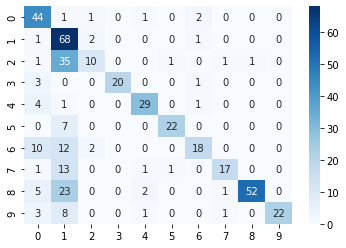

In [53]:
from sklearn.metrics import confusion_matrix
#!pip install seaborn
import seaborn as sns
c = confusion_matrix(y_test, y_pred_class)
sns.heatmap(c, annot=True,cmap='Blues');

### checking abv ibu and srm

In [54]:
feature_cols = ['ABV', 'IBU', 'SRM']
X = df[feature_cols]
y = df['type']

In [55]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=99,stratify=y)

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
from sklearn import svm
svc = svm.SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [58]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc, X_train, y_train,cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.71280277 0.69097222 0.75347222 0.72222222 0.71180556]


In [59]:
(scores.mean()*100).round()

72.0

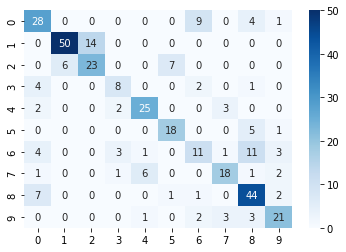

In [60]:
c = confusion_matrix(y_test, y_pred)
sns.heatmap(c, annot=True,cmap='Blues');